<a href="https://colab.research.google.com/github/carminebucci/Image-Colorization-via-Deep-Convolutional-Networks/blob/master/Demo_Image_Colorization_via_Deep_ConvNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Colorization via Deep Convolutional Networks

This is the implementation in Keras of the system develeped by Zhang et al. in their research http://richzhang.github.io/colorization/

The report produced is available here: http://tiny.cc/2j8alz

### **Get the model.** Download the colorization model and the pretreined weight.

Download the model from Github 

In [1]:
!git clone https://github.com/carminebucci/Image-Colorization-via-Deep-Convolutional-Networks.git

Cloning into 'Image-Colorization-via-Deep-Convolutional-Networks'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 39 (delta 11), reused 27 (delta 4), pack-reused 0
Unpacking objects: 100% (39/39), done.


Download the pretreined weight

In [2]:
!rm /content/Image-Colorization-via-Deep-Convolutional-Networks/data/util/colorization_release_v2_norot.h5
!wget -P /content/Image-Colorization-via-Deep-Convolutional-Networks/data/util https://github.com/carminebucci/Image-Colorization-via-Deep-Convolutional-Networks/blob/master/data/util/colorization_release_v2_norot.h5?raw=true
!mv /content/Image-Colorization-via-Deep-Convolutional-Networks/data/util/colorization_release_v2_norot.h5?raw=true /content/Image-Colorization-via-Deep-Convolutional-Networks/data/util/colorization_release_v2_norot.h5

--2020-03-14 22:01:13--  https://github.com/carminebucci/Image-Colorization-via-Deep-Convolutional-Networks/blob/master/data/util/colorization_release_v2_norot.h5?raw=true
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/carminebucci/Image-Colorization-via-Deep-Convolutional-Networks/raw/master/data/util/colorization_release_v2_norot.h5 [following]
--2020-03-14 22:01:13--  https://github.com/carminebucci/Image-Colorization-via-Deep-Convolutional-Networks/raw/master/data/util/colorization_release_v2_norot.h5
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/carminebucci/Image-Colorization-via-Deep-Convolutional-Networks/master/data/util/colorization_release_v2_norot.h5 [following]
--2020-03-14 22:01:13--  https://media.githubusercontent.c

Move to project directory

In [3]:
cd /content/Image-Colorization-via-Deep-Convolutional-Networks

/content/Image-Colorization-via-Deep-Convolutional-Networks


### **Colorization process.**

Import all required libraries and files.

In [4]:
import warnings
warnings.filterwarnings("ignore")

from os.path import join as pjoin
from skimage.transform import resize
from skimage.io import imread
from skimage import color
from matplotlib import pyplot as plt
from kmodel2 import get_model

import scipy.ndimage.interpolation as sni
import numpy as np

data_root = pjoin("data")
weights_fname  = pjoin(data_root, "util", "colorization_release_v2_norot.h5")
ann_mean_fname = pjoin(data_root, "util", "pts_in_hull.npy")

Using TensorFlow backend.


**Load the Model and Weights**

In [5]:
net = get_model(weights_fname, pretrained = True)












Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 1)       0         
_________________________________________________________________
bw_conv1_1 (Conv2D)          (None, 224, 224, 64)      640       
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, 112, 112, 64)      36928     
_________________________________________________________________
conv1_2norm (CustomBN)       (None, 112, 112, 64)      128       
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 11

In [6]:
(H_in,  W_in)  = net.layers[0].input_shape[1:3] # get input shape
(H_out, W_out) = net.layers[-1].output_shape[1:3] # get output shape

print("Input dimensions of the model : {} x {}".format(H_in, W_in))
print("Output dimensions of the model:  {} x {}".format(H_out, W_out))

Input dimensions of the model : 224 x 224
Output dimensions of the model:  56 x 56


**Annealed-Mean**

In [7]:
pts_in_hull = np.load(ann_mean_fname) # load cluster centers
W = net.layers[-1].get_weights()
W[0][0,0,:,:] = pts_in_hull
net.layers[-1].set_weights( W )
print("Annealed-Mean Parameters populated")

Annealed-Mean Parameters populated


**Loading the image.** Next, we need to load our image of choice. We will convert the image at its full resolution to Lab and keep it's L value; we will concatenate the network's output color to it! We then resize the image to the network input size, convert to Lab, and only keep the resized L, since network of course does not get any color inputs!

In [0]:
img_fname  = pjoin(data_root, "imgs", "img3.jpg") #modify here to colorize other images
img_rgb    = imread(img_fname)
img_rgb_rs = resize(img_rgb,(H_in,W_in))
img_lab, img_lab_rs = color.rgb2lab(img_rgb), color.rgb2lab(img_rgb_rs)
img_l, img_l_rs   = img_lab[:,:,0], img_lab_rs[:,:,0] # pull out L channel

**Colorization time!** Now it is time to run the network. We subtract 50 from the L channel (for mean centering), push it into the network, and run a forward pass. Then, we take the output from class8_ab, resize it to the full resolution concatenate with the L channel, convert to rgb, and display the result.

In [15]:
# subtract 50 for mean-centering and forward the network
X = np.zeros((1,H_in,W_in,1), dtype = np.float32)
X[0,:,:,0] = img_l_rs - 50

Y = net.predict(X)
print("Y predicted")

Y predicted


**Predicted a and b channel.**

<Figure size 1728x1080 with 0 Axes>

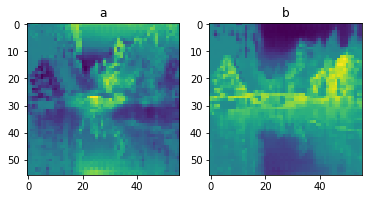

In [16]:
ab_dec = Y[0] 

a = ab_dec[:,:,0]
b = ab_dec[:,:,1]

plt.figure(figsize=(24, 15))
plt.figure()
plt.subplot(121)
plt.title("a")
plt.imshow(a)
plt.subplot(122)
plt.title("b")
plt.imshow(b)

Upsample to match size of original image L

In [17]:
H_orig, W_orig = np.shape(img_rgb)[0], np.shape(img_rgb)[1]
ab_dec_us = sni.zoom(ab_dec,(1.*H_orig/H_out,1.*W_orig/W_out,1))
print("Shape of ab_dec_us   = {}".format(np.shape(ab_dec_us)))

img_lab_out = np.concatenate((img_l[:,:,np.newaxis],ab_dec_us),axis=2)
img_rgb_out = (255*np.clip(color.lab2rgb(img_lab_out),0,1)).astype('uint8')
print("Shape of img_rgb_out = {}".format(np.shape(img_rgb_out)))

Shape of ab_dec_us   = (675, 900, 2)
Shape of img_rgb_out = (675, 900, 3)


Create grayscale version of image (just for displaying).


In [0]:
img_lab_bw = img_lab.copy()
img_lab_bw[:,:,1:] = 0
img_rgb_bw = color.lab2rgb(img_lab_bw)

 **Plot the result** compared with the original, the grayscale image, and the L channel.

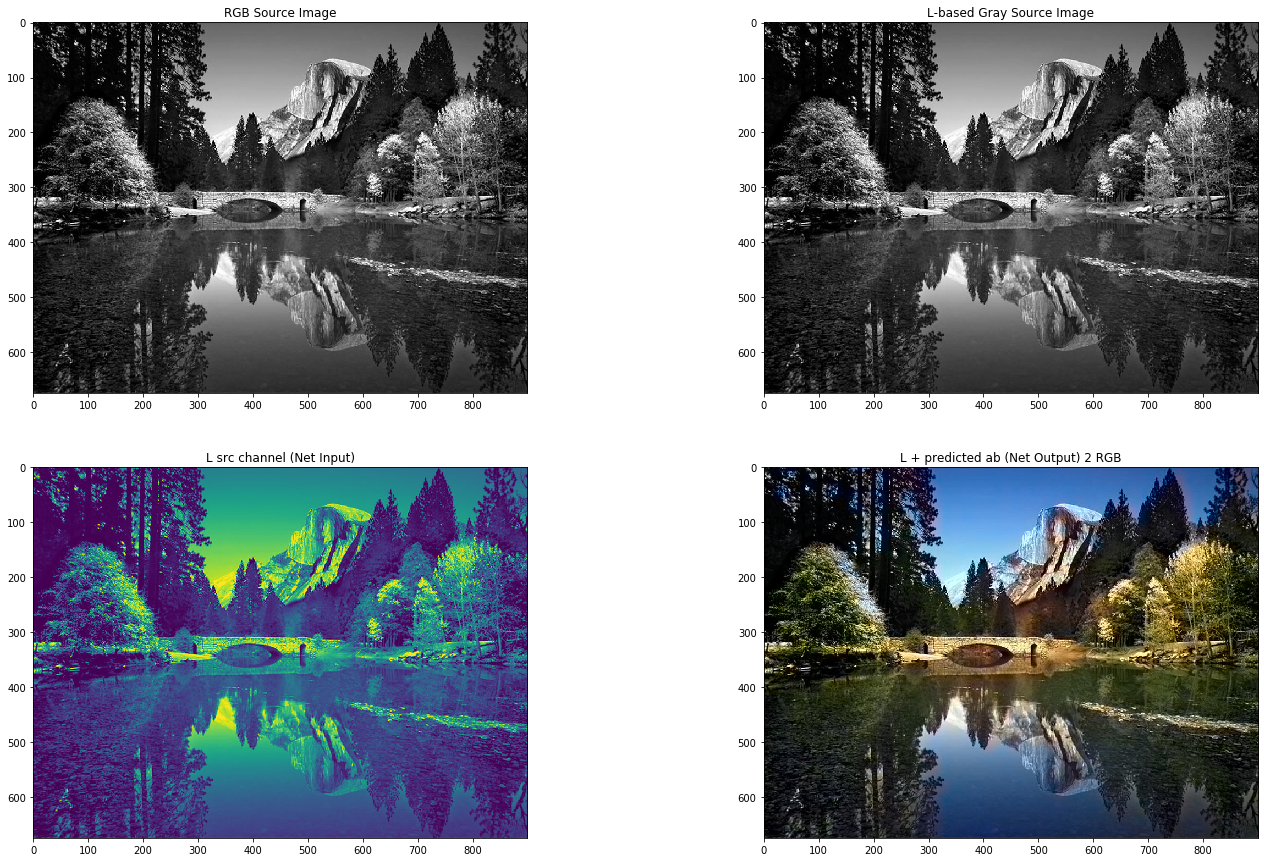

In [19]:
plt.figure(figsize=(24, 15))
plt.subplot(221)
plt.title("RGB Source Image")
plt.imshow(img_rgb)
plt.subplot(222)
plt.title("L-based Gray Source Image")
plt.imshow(img_rgb_bw)
plt.subplot(223)
plt.title("L src channel (Net Input)")
plt.imshow(img_l)
plt.subplot(224)
plt.title("L + predicted ab (Net Output) 2 RGB")
plt.imshow(img_rgb_out)